In [1]:
# Imports:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

import spacy
# Load Spacy's language model:
spacy_ner = spacy.load('en_core_web_lg')

### Preparing the Data:

In [2]:
df = pd.read_csv('Combined_SPA_Callback.csv')
df

,Date,ID,Text
0,26-Jul-17,1.010040e+11,please call daughter Dianne Thomas 07920 07565...
1,28-Jul-17,1.010040e+11,please speak to sister - Alyson Powell on abpv...
2,28-Jul-17,1.010040e+11,KELLY HAS RUNG - HER PARENTS ARE DUE TO HAVE W...
3,31-Jul-17,1.010040e+11,"Mark Hitchings, Scheme Manager Swn Yr Afon con..."
4,28-Jul-17,1.010040e+11,SON BRIAN HASFORD RUN G- HE IS RESIDENT IN AUS...
...,...,...,...
11353,13-Jun-23,1.010000e+11,"Enquiring about a downstairs toilet, states he..."
11354,13-Jun-23,1.010000e+11,Phoning on behalf on her mother she has no fee...
11355,13-Jun-23,1.010000e+11,States on saturday they had to call an ambulan...
11356,13-Jun-23,1.010000e+11,Nadia Obaji daughter of Abdel Obaji contacted ...


In [3]:
# Checking if a sentence is in caps:
def calculate_capital_percentage(string):
    total_letters = len(re.sub(r'[^a-zA-Z]', '', string))
    capital_letters = len(re.sub(r'[^A-Z]', '', string))
    capital_percentage = (capital_letters / total_letters) * 100
    return capital_percentage

# Function to clean text for NER:
def clean_text_for_NER(text):
    # Remove newline characters:
    text = re.sub(r'[\n\r]+', '. ',text)
    # Only keep Alphabets, Digits, Spaces, and Commonly Used Punctuations:
    text = re.sub(r'[^a-zA-Z0-9\s?,:"!.\']', '', text)
    # Remove extra spaces:
    text = re.sub(r'\s{2,}', ' ', text)
    # Join digits together:
    text = re.sub('(?<=\d) (?=\d)', '', text)
    text = text.strip()
    if calculate_capital_percentage(text) > 65:
        text = text.lower()
    return text

# Creating a list of sentences:
sentences = list(df["Text"])

# Clean the text
cleaned_data = [clean_text_for_NER(text) for text in sentences]

### Working with Spacy to Generate Triplets (Subject Phrase + Verb + Object Phrase):

In [4]:
# This cell takes ~2 mins to run:

# Function to perform NER using NLTK:
def perform_spacy_ner(text):
    named_entities = spacy_ner(text)
    return named_entities

# Perform NER
ner_data = [perform_spacy_ner(text) for text in cleaned_data]

In [23]:
triplet_results = []
noun_phrases_results = []
for sentence_ner in ner_data:
    # Get Noun Phrases:
    noun_phrases_raw = [chunk.text for chunk in sentence_ner.noun_chunks]
    
    # Getting unique Noun Phrases:
    noun_phrases_set = set(noun_phrases_raw)
    noun_phrases_unique = list(noun_phrases_set)
    noun_phrases = [phrase1 for phrase1 in noun_phrases_unique if not any(phrase1 in phrase2 for phrase2 in noun_phrases_unique if phrase1 != phrase2)]
    noun_phrases_results.append(noun_phrases)
    
    # Get the root of the dependency tree:
    root_tokens = [token for token in sentence_ner if token.head == token]

    # Recursive function to traverse the tree:
    def traverse_tree(token, depth=0):
        if token.dep_ == "ROOT":
            verb = token.text
        if "subj" in token.dep_:
            subjects.append(token.text)
        if "obj" in token.dep_:
            objects.append(token.text)
        for child in token.children:
            traverse_tree(child, depth + 1)
        return subjects, objects

    sentence_triplets=[]
    # Traversing the tree for every Root Token:
    for verb in root_tokens:
        subjects = []
        objects = []
        subjects, objects = traverse_tree(verb)

        # Getting Subject Phrases:
        subject_phrases = [phrase for phrase in noun_phrases if any(subj in phrase for subj in subjects)]\
        + [subj for subj in subjects if not any(subj in phrase for phrase in noun_phrases)]

        # Getting Object Phrases:
        object_phrases = [phrase for phrase in noun_phrases if any(obj in phrase for obj in objects)]\
        + [obj for obj in objects if not any(obj in phrase for phrase in noun_phrases)]
        
        # Append triplet into list of sentence triplets:
        sentence_triplets.append([" ".join(subject_phrases), verb.text, " ".join(object_phrases)])
        
    # Append the list of triplets into results:
    triplet_results.append(sentence_triplets)

In [29]:
cleaned_data[3]

'Mark Hitchings, Scheme Manager Swn Yr Afon contacted the department requesting an assessment on Mary behalf. Client is displaying paraniod behaviour, belives that other residents are spraying things in her flat. Mrs Hughes is causing arguments between other residents within the complex. Please contact Mark 01443673329'

In [30]:
[sent for sent in ner_data[3].sents]

[Mark Hitchings, Scheme Manager Swn Yr Afon contacted the department requesting an assessment on Mary behalf.,
 Client is displaying paraniod behaviour, belives that other residents are spraying things in her flat.,
 Mrs Hughes is causing arguments between other residents within the complex.,
 Please contact Mark 01443673329]

In [31]:
spacy.displacy.render(ner_data[3])

In [32]:
triplet_results[3]

[['Mark Hitchings', 'contacted', 'the department an assessment Mary behalf'],
 ['Client other residents', 'displaying', 'paraniod behaviour things flat'],
 ['Mrs Hughes', 'causing', 'the complex arguments other residents'],
 ['', 'contact', 'Mark Hitchings']]

In [33]:
noun_phrases_results[3]

['the complex',
 'arguments',
 'the department',
 'Client',
 'Scheme Manager Swn Yr Afon',
 'an assessment',
 'paraniod behaviour',
 'things',
 'Mary behalf',
 'other residents',
 'Mrs Hughes',
 'Mark Hitchings']

In [34]:
# Function to tokenize text:
def tokenize_text(text):
    # Tokenize sentences:
    sentences = sent_tokenize(text)
    # Tokenize words:
    words = []
    for sentence in sentences:
        words += word_tokenize(sentence)
    return words

# Function to remove stopwords:
def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return words

# Function to convert tokens into original text:
def words_to_text(words):
    current_text = ' '.join(words)
    return(current_text)

# Function to lemmatize words:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word, tag in pos_tag(words):
        # Map POS tag to first letter used by WordNetLemmatizer:
        tag = tag[0].lower() if tag[0].lower() in ['a', 'r', 'n', 'v'] else wordnet.NOUN
        lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_words

# Function to stem words:
def stem_words(words):
    stemmer = PorterStemmer()
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

# Function to perform NER using NLTK:
def perform_ner(text):
    named_entities = ne_chunk(pos_tag(word_tokenize(text)))
    return named_entities

# Function to extract sentiment:
def extract_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

In [35]:
# Perform NER
ner_data = [perform_ner(text) for text in cleaned_data]

In [36]:
sentences[0]

'please call daughter Dianne Thomas 07920 075650 - she is looking for support with her mum '

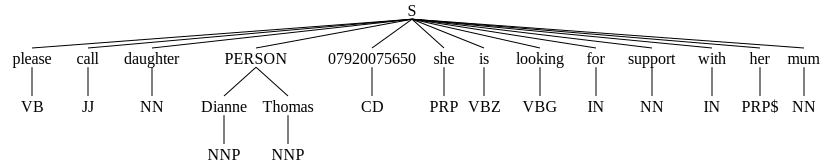

In [37]:
# Same example in an NER tree form:
ner_data[0]

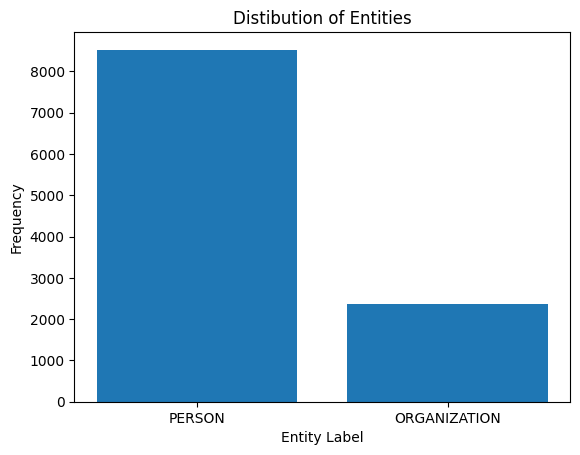

In [38]:
# Extract named entities and their labels:

organizations = []
persons = []
geopoliticals = []
locations = []
ner_stopwords = ["Please","PLEASE","URGENT","ONLY","ASAP","CALLBACK","CALL"]

entities = []
labels = []
for doc in ner_data:
    for chunk in doc:
        if hasattr(chunk, 'label'):
            flag = 0
            if chunk.label()=="ORGANIZATION":
                organization = ' '.join(c[0] for c in chunk)
                if organization not in ner_stopwords:
                    organizations.append(organization)
                    flag = 1 
            elif chunk.label()=="PERSON":
                person = ' '.join(c[0] for c in chunk)
                if len(person)>2 and person not in ner_stopwords:
                    persons.append(' '.join(c[0] for c in chunk))
                    flag = 1
            if flag == 1:
                entities.append(' '.join(c[0] for c in chunk))
                labels.append(chunk.label())

# Count the frequency of each label:
label_counts = Counter(labels)

# Plot the frequency of each label:
plt.bar(label_counts.keys(), label_counts.values())
plt.title('Distibution of Entities')
plt.xlabel('Entity Label')
plt.ylabel('Frequency')
plt.show()

In [39]:
# Tokenize text
tokenized_data = [tokenize_text(text) for text in cleaned_data]

# Remove stopwords
no_stopwords_data = [remove_stopwords(words) for words in tokenized_data]

# Lemmatize words
lemmatized_data = [lemmatize_words(words) for words in no_stopwords_data]

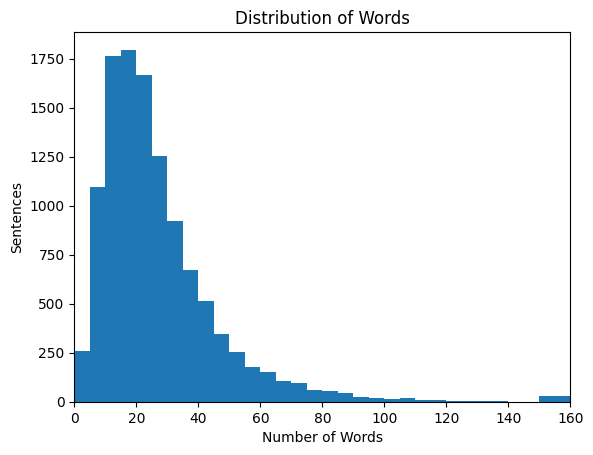

In [40]:
# Calculating number of
no_of_tokens = [len(sentence) for sentence in lemmatized_data]
bin_width = 5
threshold = 150

# Calculate the bin edges:
bins = list(range(min(no_of_tokens)-1, threshold + bin_width, bin_width)) + [max(no_of_tokens) + bin_width]

# Plotting the distribution as a histogram:
plt.hist(no_of_tokens, bins=bins)
plt.xlabel('Number of Words')
plt.ylabel('Sentences')
plt.title('Distribution of Words')

# Setting x-axis limits and showing plot:
plt.xlim(0, 160)
plt.show()

In [41]:
# Sort by rank (most common to least common)
sorted_counter = sorted(Counter(organizations).items(), key=lambda x: x[1], reverse=True)
print("Top 10 most common occurences of Organizations/ Products:")
for item, count in sorted_counter[:10]:
    print('{}: {}'.format(item,count))
    
# Sort by rank (most common to least common)
sorted_counter = sorted(Counter(persons).items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 most common occurences of Persons:")
for item, count in sorted_counter[:10]:
    print('{}: {}'.format(item,count))

Top 10 most common occurences of Organizations/ Products:
WCCIS: 77
GP: 75
SPA: 63
FAO: 62
COPD: 59
RGH: 55
NHS: 45
Social Services: 42
RCT: 28
OT: 27

Top 10 most common occurences of Persons:
Client: 488
Daughter: 165
Son: 132
Rachel Thomas: 122
Jones: 89
Trivallis: 65
Williams: 59
Sally Prosser: 50
David: 49
Lewis: 45
